<a href="https://colab.research.google.com/github/gustavor10silva/alura_imersao_dados_4/blob/main/2_limpeza_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Importando bibliotecas

In [23]:
import pandas as pd
from pandas.core.dtypes.missing import isna
import seaborn as sns
from seaborn import boxplot

!pip install pandasql
import pandasql as ps
from pandasql import sqldf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=4d35aeb1eda60ac58a88b8c2a672f98570816938f41de7b5674521443133adcf
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


# 2 Tratamento de dados

Neste tópico, serão executados os pontos de melhoria que foram identificados na etapa de análise exploratória.

Os principais pontos são:

* Tratamento na coluna de Valor, que está como string
* Identificação de outliers com boxplot, consultas em SQL e o gráfico pairplot da biblioteca seaborn
* Remoção desses outliers
* Produção de um dataframe com todos esses tratamentos e salvamento do mesmo no drive, para não ser necessário executar tudo de novo

Feito esses tratamentos, os dados estarão prontos para partirmos para a etapa de modelagem de dados, onde vamos cruzar esses dados com dados de outras fontes.

In [4]:
url = "https://gist.githubusercontent.com/tgcsantos/3bdb29eba6ce391e90df2b72205ba891/raw/22fa920e80c9fa209a9fccc8b52d74cc95d1599b/dados_imoveis.csv"
df_bruto = pd.read_csv(url)
df_bruto.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000


Primeiro, vamos tratar a coluna de valor, que está como string, e vamos passá-la para o formato numérico.

A célula abaixo faz um split nos dados da coluna de valor e constrói um dataset.

In [5]:
trata_valor = df_bruto["Valor"].str.split(expand = True)
trata_valor

,0,1,2
0,R$,7.000.000,None
1,R$,3.700.000,None
2,R$,380.000,None
3,R$,685.000,None
4,R$,540.000,None
...,...,...,...
10003,R$,665.000,None
10004,R$,2.300.000,None
10005,R$,1.050.000,None
10006,R$,2.200,/Mês


Note que a coluna 0 tem apenas o valor 'R$':

In [6]:
trata_valor[0].unique()

array(['R$'], dtype=object)

A coluna 1 tem o valor que precisamos. Vamos retirar o ponto e transformar os dados em int:

In [7]:
trata_valor[1] = trata_valor[1].str.replace(".", "").astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


Agora, note que a coluna 3 possui valores como '/Mês', '/Ano', '/Dia':

In [8]:
trata_valor[2].unique()

array([None, '/Mês', '/Ano', '/Dia'], dtype=object)

Esses valores indicam que o dado do imóvel em questão não refere-se ao preço do imóvel, mas sim ao preço do aluguel por dia, mês ou ano, o que não nos interessa.

Então vamos remover esses dados.

In [9]:
trata_valor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       10008 non-null  object
 1   1       10008 non-null  int64 
 2   2       852 non-null    object
dtypes: int64(1), object(2)
memory usage: 234.7+ KB


Vamos construir um novo dataframe df_silver, com as colunas de valor que construímos acima:

In [10]:
df_silver = df_bruto.drop(columns=["Valor"])
df_silver[["Moeda", "Valor", "TipoValor"]] = trata_valor
df_silver

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,TipoValor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$,7000000,None
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$,3700000,None
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$,380000,None
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$,685000,None
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$,540000,None
...,...,...,...,...,...,...,...,...,...,...
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$,665000,None
10004,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$,2300000,None
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$,1050000,None
10006,"Rua Manuel Onha, , 514",Vila Oratório,São Paulo,185,3,2,2,R$,2200,/Mês


Agora, vamos excluir a coluna "Moeda", que é inútil, e vamos excluir os dados que possuem preço de aluguel.

In [12]:
df_silver.drop(columns=["Moeda"], inplace=True)

mask = df_silver["TipoValor"].isna()
df_silver = df_silver[mask]

df_silver.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,TipoValor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000,None
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000,None
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000,None
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000,None
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000,None


Finalmente, a coluna "TipoValor" não é mais útil, então vamos excluí-la:

In [13]:
df_silver.drop(columns = ["TipoValor"], inplace = True)
df_silver.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000


# 3 Tratamento de outliers

Conforme veremos a seguir, os outliers atrapalham a interpretação da base de dados e atrapalharão os modelos de regressão que usaremos posteriormente.

Por conta disso, esses outliers serão removidos. Antes de começarmos a lidar com esses outliers, vejamos quantos dados temos antes da remoção:

In [34]:
len(df_silver)

9156

## 3.1 Primeira etapa

Vamos começar o tratamentos de outliers plotando os boxplots das colunas numéricas.

Isso nos ajudará a identificar as outliers dessas colunas.

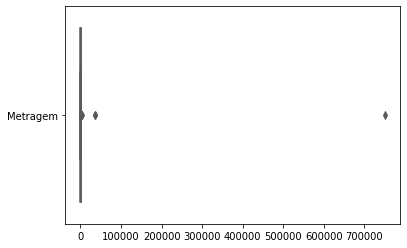

In [17]:
boxplotMetragem = sns.boxplot(data=df_silver[['Metragem']], orient="h", palette="Set2")
boxplotMetragem

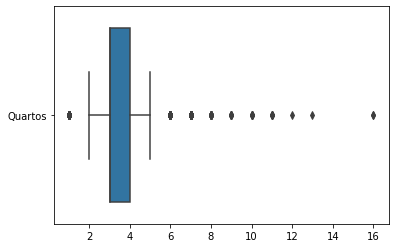

In [18]:
axQuartos = sns.boxplot(data = df_silver[['Quartos']], orient="h")
axQuartos

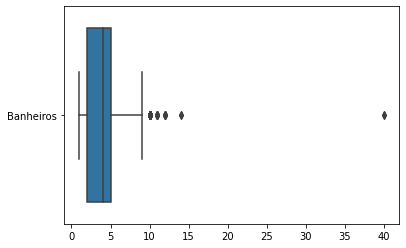

In [19]:
axBanheiros = sns.boxplot(data = df_silver[['Banheiros']], orient="h")
axBanheiros

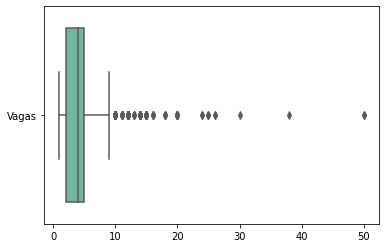

In [20]:
axVagas = sns.boxplot(data = df_silver[['Vagas']], orient="h", palette="Set2")
axVagas

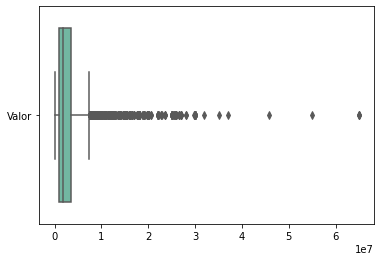

In [21]:
axValor = sns.boxplot(data = df_silver[['Valor']], orient="h", palette="Set2")
axValor

Com base nos primeiros boxplots que fizemos acima, podemos fazer uma exclusão de outliers com a consulta SQL abaixo:

In [24]:
query = """SELECT *
           FROM df_silver
           WHERE Metragem < 5000 AND Metragem >= 20
           AND Vagas <= 10
           AND Banheiros <= 10
           AND Quartos <= 10
           AND Valor > 100000
           ORDER BY Valor DESC"""
trata_outliers_v1 = sqldf(query)
trata_outliers_v1

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,None,Jardim América,São Paulo,773,4,4,10,45825000
1,Rua Inglaterra,Jardim Europa,São Paulo,756,5,4,10,37000000
2,Rua ESão Pauloanha,Jardim Europa,São Paulo,1400,4,8,6,35000000
3,None,Jardim Petrópolis,São Paulo,912,4,6,10,32000000
4,None,Jardim Paulista,São Paulo,1060,5,5,4,30000000
...,...,...,...,...,...,...,...,...
8979,Rua Júlio Salusse,Vila Aurea,São Paulo,182,3,1,2,165000
8980,Rua Victória Simionato,Vila Paranaguá,São Paulo,45,1,1,1,160000
8981,"Rua Luís Botta, 1137",Cidade São Mateus,São Paulo,61,1,1,1,147288
8982,None,Cidade São Mateus,São Paulo,61,1,1,1,147288


Vejamos quantos dados removemos nessa primeira etapa:

In [41]:
antes = len(df_silver)
depois1 = len(trata_outliers_v1)

print("Dados antes da remoção  : ", antes)
print("Dados depois da remoção : ", depois1)
print("Dados removidos:          ", antes - depois1)
print("% Dados removidos:        ", (1 - depois1 / antes) * 100 )

Dados antes da remoção  :  9156
Dados depois da remoção :  8984
Dados removidos:           172
% Dados removidos:         1.8785495849716005


## 3.2 Segunda etapa

Na segunda etapa, vamos plotar os boxplots novamente e fazer uma nova remoção dos outliers que ainda estão discrepantes.

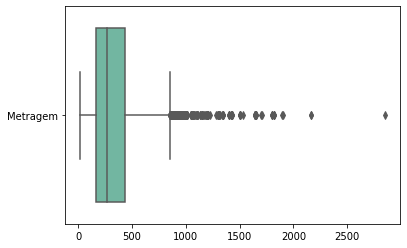

In [25]:
boxplotMetragem_tratado = sns.boxplot(data=trata_outliers_v1[['Metragem']], orient="h", palette="Set2")
boxplotMetragem_tratado

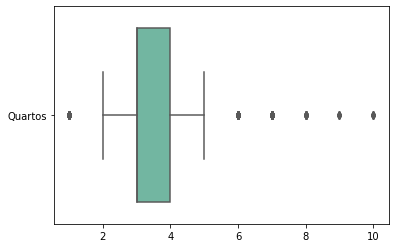

In [26]:
boxplotQuartos_tratado = sns.boxplot(data=trata_outliers_v1[['Quartos']], orient="h", palette="Set2")
boxplotQuartos_tratado

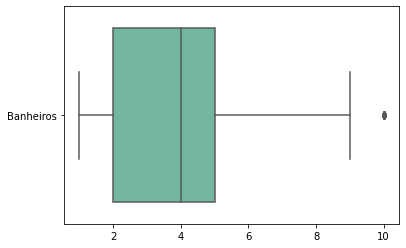

In [27]:
boxplotBanheiros_tratado = sns.boxplot(data=trata_outliers_v1[['Banheiros']], orient="h", palette="Set2")
boxplotBanheiros_tratado

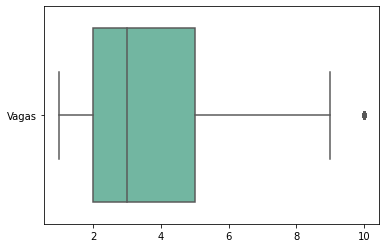

In [28]:
boxplotVagas_tratado = sns.boxplot(data=trata_outliers_v1[['Vagas']], orient="h", palette="Set2")
boxplotVagas_tratado

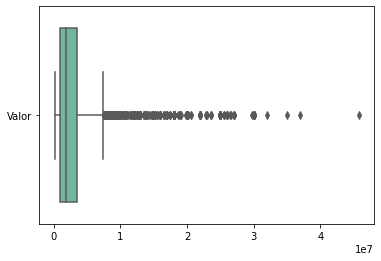

In [29]:
boxplotValor_tratado = sns.boxplot(data=trata_outliers_v1[['Valor']], orient="h", palette="Set2")
boxplotValor_tratado

Plotando um novo pairplot para observar os outliers:

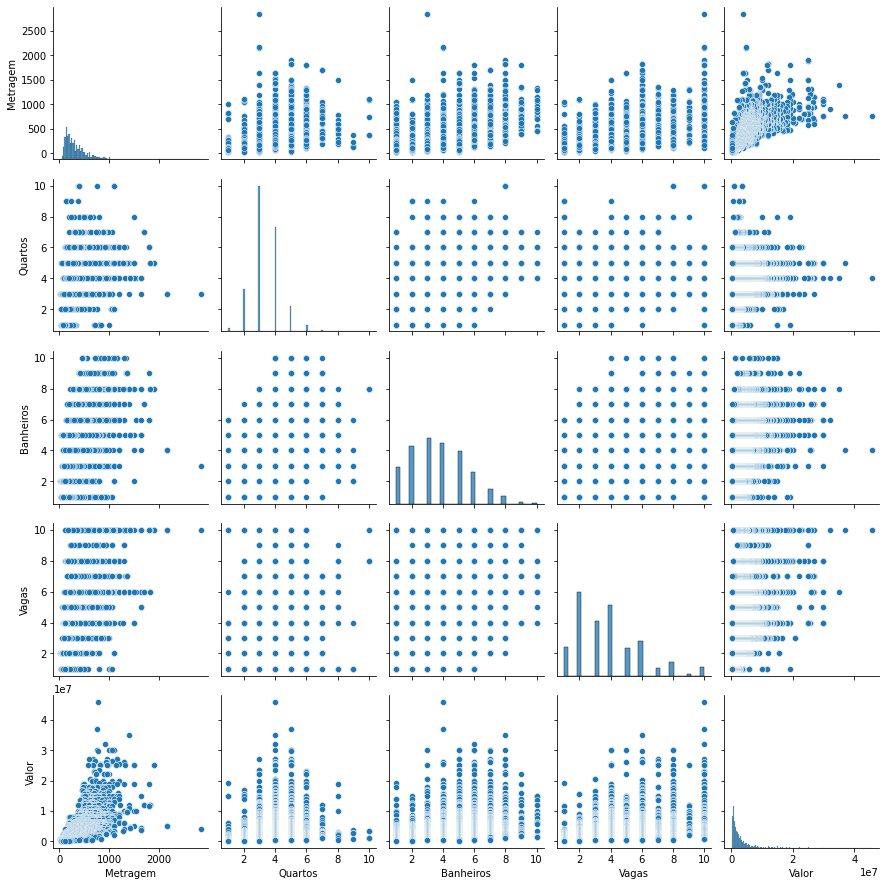

In [30]:
sns.pairplot(trata_outliers_v1)

Ainda vemos outliers nas colunas de valor e preço, então vamos removê-los:

In [31]:
query = """SELECT *
           FROM trata_outliers_v1
           WHERE Quartos <= 9
           AND Valor <= 3.5e7
           ORDER BY Quartos DESC"""
trata_outliers_v2 = sqldf(query)
trata_outliers_v2

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Rua Caramuru, 100",Saúde,São Paulo,380,9,4,4,3700000
1,"Alameda Franca, 587",Jardim Paulista,São Paulo,137,9,2,1,2600000
2,"Alameda Franca, 587",Jardim Paulista,São Paulo,142,9,2,1,2600000
3,Alameda Franca,Jardim Paulista,São Paulo,150,9,2,1,2600000
4,Alameda Franca,Jardim Paulista,São Paulo,155,9,2,1,2600000
...,...,...,...,...,...,...,...,...
8970,None,Vila Nova Curuçá,São Paulo,107,1,1,1,188682
8971,None,Vila Nova Curuçá,São Paulo,112,1,1,1,188682
8972,Rua Victória Simionato,Vila Paranaguá,São Paulo,45,1,1,1,160000
8973,"Rua Luís Botta, 1137",Cidade São Mateus,São Paulo,61,1,1,1,147288


In [32]:
trata_outliers_v2.isnull().sum().sort_values(ascending = False)

Rua          2967
Bairro         10
Cidade          0
Metragem        0
Quartos         0
Banheiros       0
Vagas           0
Valor           0
dtype: int64

In [46]:
antes = len(df_silver)
depois1 = len(trata_outliers_v1)
depois2 = len(trata_outliers_v2)

print("Dados antes da remoção     : ", antes)
print("Dados depois da etapa 1    : ", depois1)
print("Dados removidos na etapa 1 : ", antes - depois1, "\n")

print("Dados depois da etapa 2    : ", depois2)
print("Dados removidos na etapa 2 : ", depois1 - depois2, "\n")

print("% Dados removidos no total : ", (1 - depois2 / antes) * 100 )

Dados antes da remoção     :  9156
Dados depois da etapa 1    :  8984
Dados removidos na etapa 1 :  172 

Dados depois da etapa 2    :  8975
Dados removidos na etapa 2 :  9 

% Dados removidos no total :  1.9768457841852327


Por último, vamos salvar o df_gold, que é a nossa base de dados tratada e com outliers removidos.

In [33]:
df_gold = trata_outliers_v2
df_gold.to_csv("df_gold.csv")